In [1]:
from mflex.model.plasma_parameters_new import (
    btemp,
    bpressure,
    bdensity,
    btemp_linear,
    bpressure_linear,
    bdensity_linear,
    deltapres,
    deltaden,
)
import numpy as np
import matplotlib.pyplot as plt
from mflex.model.field.bfield_model import magnetic_field_test
from mflex.simulate.simulate_boundary import dipole
from mflex.plot.plot_magnetogram import plot_fieldlines_polar_thesis

In [2]:
z0 = 0.2
deltaz = z0 / 10.0

t_photo = 5600.0  # Temperature at z = 0 (on photosphere) in Kelvin
t_corona = 2.0 * 10.0**6  # Temperature at z = 2.0 (at 20 Mm) in Kelvin
t0 = (t_photo + t_corona * np.tanh(z0 / deltaz)) / (
    1.0 + np.tanh(z0 / deltaz)
)  # Temperature at z = z0 in Kelvin
t1 = (t_corona - t_photo) / (1.0 + np.tanh(z0 / deltaz))  # t_corona - t0 in Kelvin

g_solar = 274.0  # gravitational acceleration in m/s^2
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
rho_photo = 3.0 * 10**-4
b_photo = 10.0  # Gauss, NOT SI
h0 = kB * t0 / (mbar * g_solar)
h_photo = kB * t_photo / (mbar * g_solar)
p_photo = t_photo * kB * rho_photo / mbar
mu0 = 1.25663706 * 10**-6
pB_photo = (b_photo * 10**-4) ** 2 / (2 * mu0)
beta_photo = p_photo / pB_photo
l = 10**-7

h0_star = h0 * l
h_photo_star = h_photo * l

h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

In [3]:
nresol_z = 200
zmin = 0.0
zmax = z0 * 10.0
xmin = 0.0
xmax = z0 * 10.0
ymin = 0.0
ymax = z0 * 10.0
nresol_x = 100
nresol_y = 100
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z
nf_max = 100

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

In [4]:
btemp_arr_star = btemp(z_arr, z0, deltaz, t0, t1)

bpres_arr_star = bpressure(z_arr, z0, deltaz, h0_star, t0, t1)

bden_arr_star = bdensity(z_arr, z0, deltaz, h0_star, t0, t1, t_photo)

bpres_arr = 0.5 * beta_photo * bpres_arr_star
bden_arr = beta_photo / (2.0 * h_photo_star) * bden_arr_star

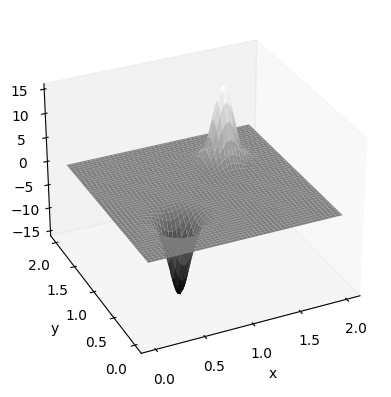

In [5]:
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * b_photo

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(y_plot, x_plot, data_bz, cmap="grey")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, -115, 0)
ax.grid(False)
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure2b.png"
# plt.savefig(plotname, dpi=300)
plt.show()

Maximum b 15.341064930175941


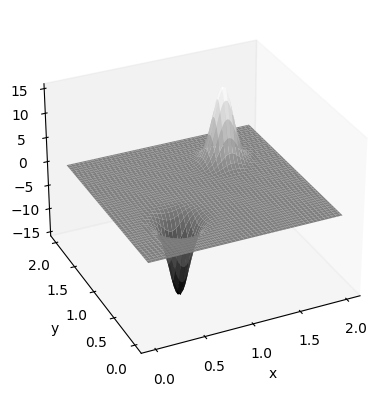

In [6]:
a = 0.22
alpha = 0.25
b = 1.0

bfield, dbfield = magnetic_field_test(
    data_bz,
    z0,
    deltaz,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

print("Maximum b", bfield.max())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, 0, 2],
    cmap="grey",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, -115, 0)
ax.grid(False)
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure2b.png"
# plt.savefig(plotname, dpi=300)
plt.show()

In [7]:
bfield_star = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, :] / b_photo
dbfield_star = dbfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, :] / b_photo

bdotgradbz_star = (
    bfield_star[:, :, :, 1] * dbfield_star[:, :, :, 1]
    + bfield_star[:, :, :, 0] * dbfield_star[:, :, :, 0]
    + bfield_star[:, :, :, 2] * dbfield_star[:, :, :, 2]
)

In [8]:
dp_arr = deltapres(z_arr, z0, deltaz, a, b, bfield_star[:, :, :, 2])
dd_arr = deltaden(z_arr, z0, deltaz, a, b, bfield_star[:, :, :, 2], bdotgradbz_star, l)

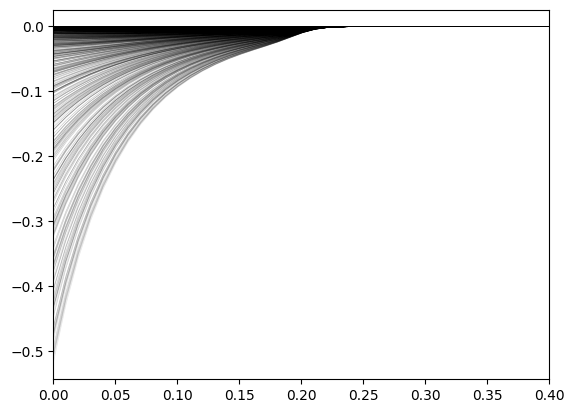

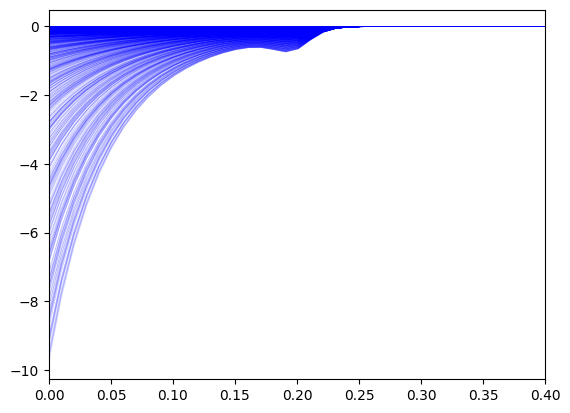

In [9]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            dp_arr[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
plt.xlim([0, 2 * z0])
plt.show()

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            dd_arr[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.xlim([0, 2 * z0])
plt.show()

In [10]:
cube1, cube2, Backpres_star = np.meshgrid(
    np.ones(nresol_x), np.ones(nresol_y), bpres_arr
)  # Dimensionless
cube1, cube2, Backden_star = np.meshgrid(np.ones(nresol_x), np.ones(nresol_y), bden_arr)

In [11]:
full_pressure_star = Backpres_star + dp_arr
full_density_star = Backden_star + dd_arr

print("pressure min", full_pressure_star.min())
print("density min", full_density_star.min())

pressure min 2.96356591230758
density min 0.48903570902816196


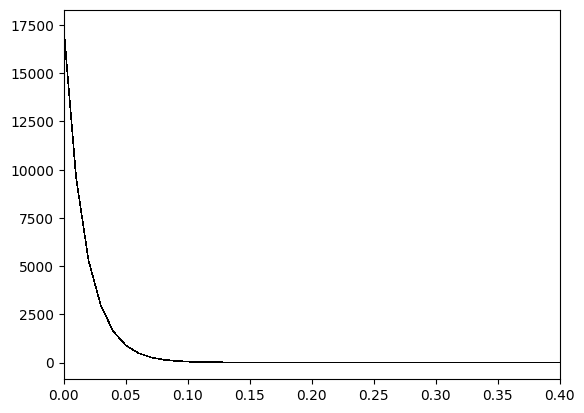

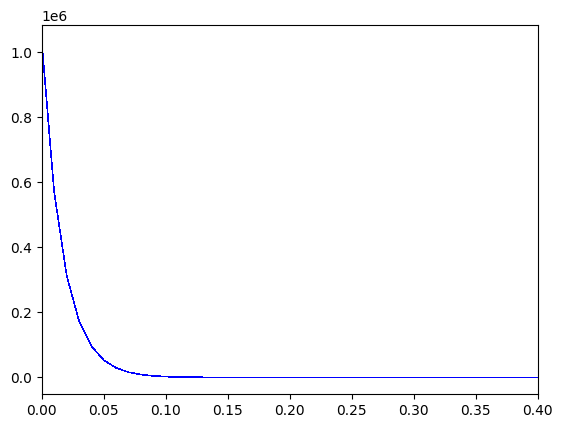

In [12]:
full_pressure = b_photo**2.0 / mu0 * full_pressure_star
full_density = b_photo**2.0 / (g_solar * l * mu0) * full_density_star

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            full_pressure_star[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
plt.xlim([0, 2 * z0])
plt.show()

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            full_density_star[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.xlim([0, 2 * z0])
plt.show()

In [13]:
btemp_arr_linear_star, bpres_arr_linear_star, bden_arr_linear_star = (
    np.zeros_like(z_arr),
    np.zeros_like(z_arr),
    np.zeros_like(z_arr),
)
temps = [t_photo, t0, t_corona]
heights = [0.0, z0, 10 * z0]
for iz, z in enumerate(z_arr):
    btemp_arr_linear_star[iz] = btemp_linear(z, temps, heights)
    bpres_arr_linear_star[iz] = bpressure_linear(z, temps, heights, t0, h0_star)
    bden_arr_linear_star[iz] = bdensity_linear(z, temps, heights, t0, h0_star, t_photo)

In [14]:
cube1, cube2, Backpres_linear_star = np.meshgrid(
    np.ones(nresol_x), np.ones(nresol_y), 0.5 * beta_photo * bpres_arr_linear_star
)  # Dimensionless
cube1, cube2, Backden_linear_star = np.meshgrid(
    np.ones(nresol_x),
    np.ones(nresol_y),
    beta_photo / (2.0 * h_photo_star) * bden_arr_linear_star,
)

In [15]:
full_pressure_linear_star = Backpres_linear_star + dp_arr
full_density_linear_star = Backden_linear_star + dd_arr

pressure min lin 8157.686561483541
density min lin 1353.9467514308112


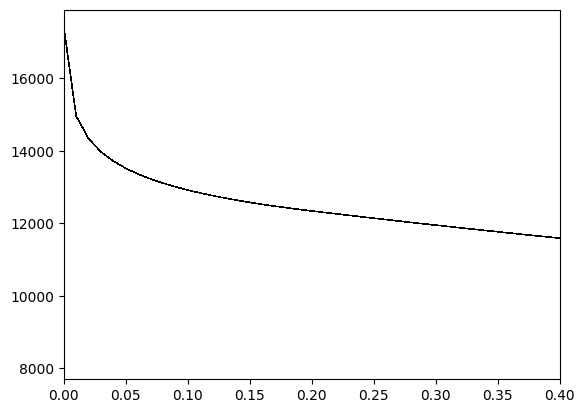

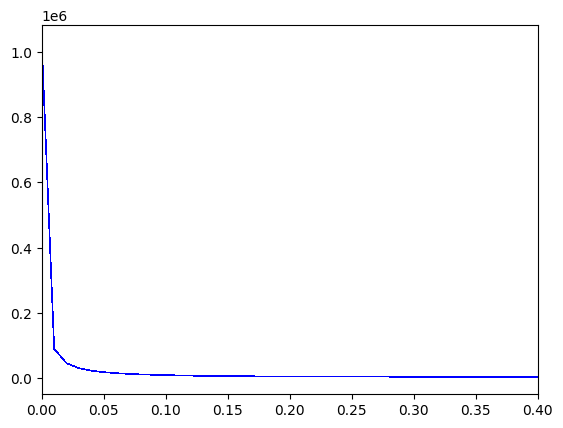

In [16]:
full_pressure_linear = b_photo**2.0 / mu0 * full_pressure_linear_star
full_density_linear = b_photo**2.0 / (g_solar * l * mu0) * full_density_linear_star

print("pressure min lin", full_pressure_linear_star.min())
print("density min lin", full_density_linear_star.min())

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            full_pressure_linear_star[iy, ix, :],
            linewidth=0.5,
            color="black",
            linestyle="solid",
            alpha=0.1,
        )
plt.xlim([0, 2 * z0])
plt.show()

for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            full_density_linear_star[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.1,
        )
plt.xlim([0, 2 * z0])
plt.show()

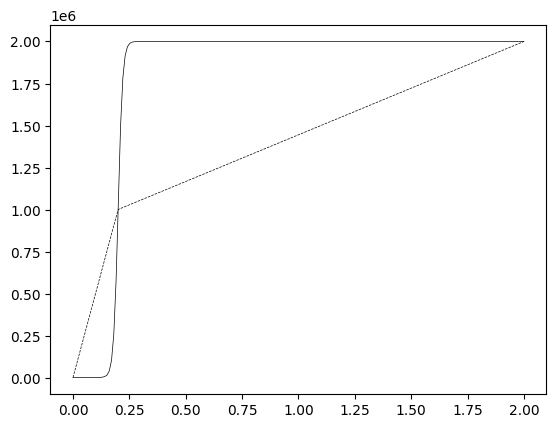

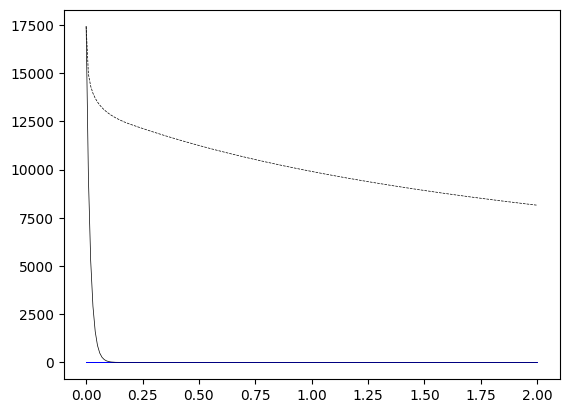

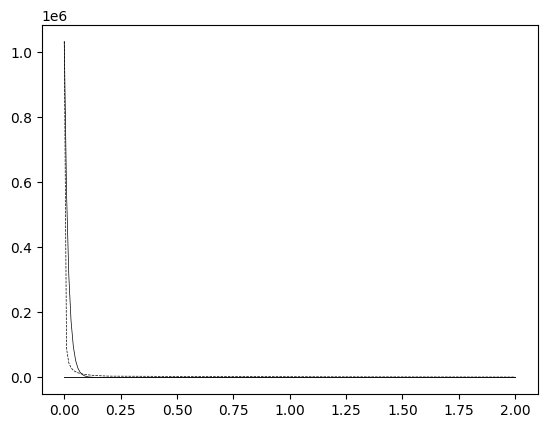

In [17]:
plt.plot(
    z_arr,
    btemp_arr_star,
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.plot(
    z_arr,
    btemp_arr_linear_star,
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.show()

plt.plot(
    z_arr,
    bpres_arr_star * 0.5 * beta_photo,
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.plot(
    z_arr,
    bpres_arr_linear_star * 0.5 * beta_photo,
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            -dp_arr[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.01,
        )
plt.show()

plt.plot(
    z_arr,
    bden_arr_star * beta_photo / (2 * h_photo_star),
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.plot(
    z_arr,
    bden_arr_linear_star * beta_photo / (2 * h_photo_star),
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            -dd_arr[iy, ix, :],
            linewidth=0.5,
            color="blue",
            linestyle="solid",
            alpha=0.01,
        )
plt.show()

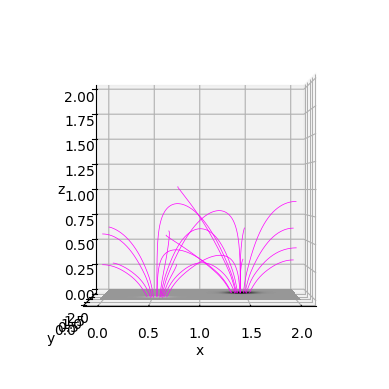

In [18]:
plot_fieldlines_polar_thesis(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Test",
    cmap="Greys"
)